# MOVIE ENSEMBLE COMPARISON

In [1]:
import polars as pl
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path

In [2]:
movie_dirs = {
    "ExE": Path('../evaluation/ensemble/'),
    "RAF-DB": Path('../evaluation/raf_db/'),
    "FER": Path('../evaluation/fer_2013/'),
}

In [3]:
movie_emotion_summary_dfs = {}
for name, mdir in movie_dirs.items():
    input_file = mdir / 'movie_emotion_summary.parquet'
    df = pl.read_parquet(input_file)
    df = df.with_columns([
        pl.max_horizontal([
            "pct_angry", "pct_fear", "pct_happy", "pct_sad", "pct_surprise"
        ]).alias("pct_max"),
    ])

    df = df.with_columns([
        pl.when(pl.col("pct_angry") == pl.col("pct_max")).then(pl.lit("angry"))
            .when(pl.col("pct_fear") == pl.col("pct_max")).then(pl.lit("fear"))
            .when(pl.col("pct_happy") == pl.col("pct_max")).then(pl.lit("happy"))
            .when(pl.col("pct_sad") == pl.col("pct_max")).then(pl.lit("sad"))
            .when(pl.col("pct_surprise") == pl.col("pct_max")).then(pl.lit("surprise"))
            .alias("dominant_emotion")
        ])

    movie_emotion_summary_dfs[name] = df


In [4]:
for model, df in movie_emotion_summary_dfs.items():
    print(f"Top emotion for model {model} is {df['dominant_emotion'].mode()}")

Top emotion for model ExE is shape: (1,)
Series: 'dominant_emotion' [str]
[
	"sad"
]
Top emotion for model RAF-DB is shape: (1,)
Series: 'dominant_emotion' [str]
[
	"surprise"
]
Top emotion for model FER is shape: (1,)
Series: 'dominant_emotion' [str]
[
	"angry"
]


In [5]:
for model, df in movie_emotion_summary_dfs.items():
    print(f"Value Count for {model} dominate emotion:")
    print(df['dominant_emotion'].value_counts())

Value Count for ExE dominate emotion:
shape: (5, 2)
┌──────────────────┬───────┐
│ dominant_emotion ┆ count │
│ ---              ┆ ---   │
│ str              ┆ u32   │
╞══════════════════╪═══════╡
│ sad              ┆ 31    │
│ surprise         ┆ 12    │
│ angry            ┆ 7     │
│ happy            ┆ 2     │
│ fear             ┆ 7     │
└──────────────────┴───────┘
Value Count for RAF-DB dominate emotion:
shape: (4, 2)
┌──────────────────┬───────┐
│ dominant_emotion ┆ count │
│ ---              ┆ ---   │
│ str              ┆ u32   │
╞══════════════════╪═══════╡
│ sad              ┆ 25    │
│ surprise         ┆ 32    │
│ happy            ┆ 1     │
│ angry            ┆ 1     │
└──────────────────┴───────┘
Value Count for FER dominate emotion:
shape: (3, 2)
┌──────────────────┬───────┐
│ dominant_emotion ┆ count │
│ ---              ┆ ---   │
│ str              ┆ u32   │
╞══════════════════╪═══════╡
│ sad              ┆ 4     │
│ angry            ┆ 29    │
│ fear             ┆ 26    │


In [41]:
31/59

0.5254237288135594

In [6]:
EMOTION_COLORS = {
    "angry": "#E74C3C",
    "fear": "#7F8C8D",
    "happy": "#FFD93D",
    "sad": "#4A90E2",
    "surprise": "#9B59B6",
}

perc_cols = ["angry_pct", "fear_pct", "happy_pct", "sad_pct", "surprise_pct"]

In [7]:
save_path = Path('../images/')

In [8]:
tidy_dfs = {}
for model, mdir in movie_dirs.items():
    input_file = mdir / 'movie_emotion_summary_tidy.parquet'
    tidy_dfs[model] = pl.read_parquet(input_file)

In [9]:
def stacked_emo_perc_by_movie(tidy_df, save_path=None, name="Model"):
    fig = px.bar(
        tidy_df,
        x="movie",
        y="pct",
        color="emotion",
        color_discrete_map=EMOTION_COLORS,
        barmode="stack",
        title=f"{name}: Emotion Distribution by Movie (Stacked %)",
        height=600,
        category_orders={
            "emotion": ["angry", "fear", "happy", "sad", "surprise"]
        },
    )

    fig.update_xaxes(tickangle=45)
    fig.update_layout(
        legend=dict(
            orientation="h", yanchor="bottom", 
            y=.99, xanchor="center", x=0.5,
            bordercolor="#000000",
            borderwidth=2, 
        )
    )
    
    if save_path:
        save_name = f"{name}_stack_emo_by_movie.png"
        fig.write_image(save_path / save_name)
    fig.show()

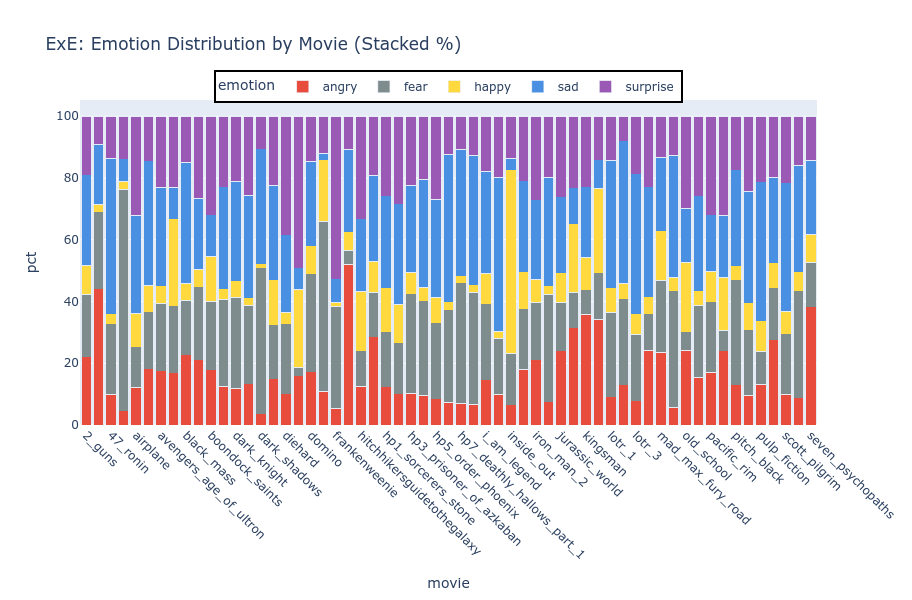

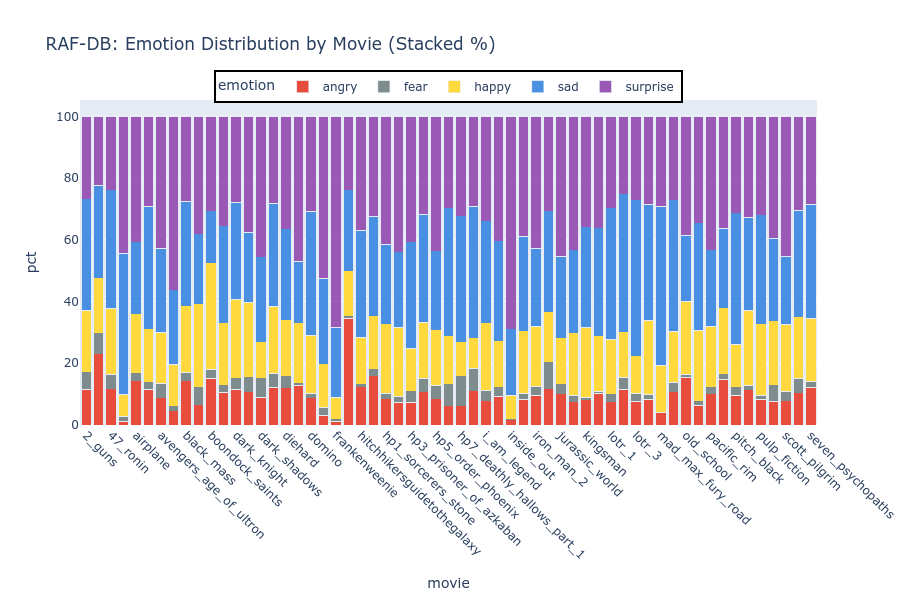

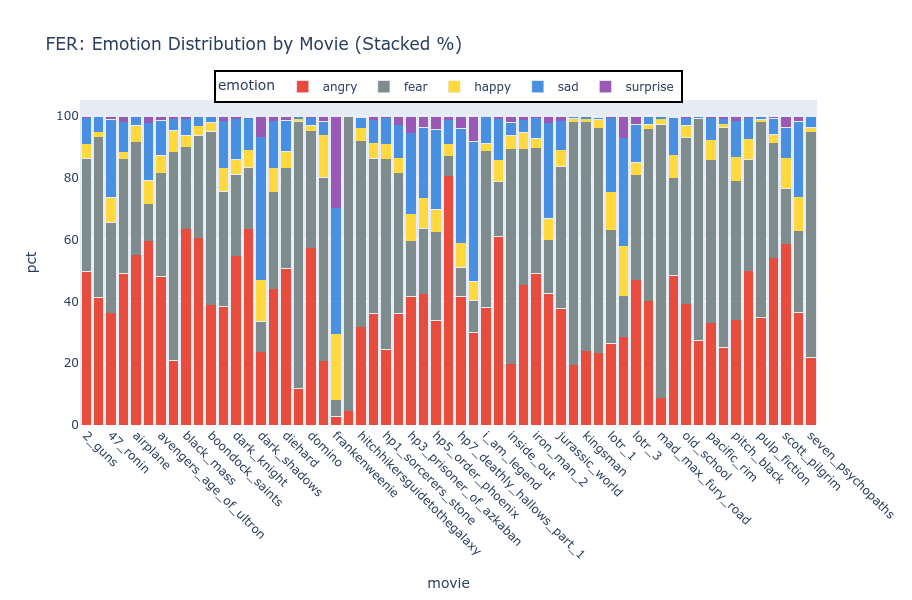

In [10]:
for model, tidy in tidy_dfs.items():
    stacked_emo_perc_by_movie(tidy, save_path=save_path, name=model)

In [11]:
comedies = [
    'airplane',
    'dark_shadows',
    'dazed_and_confused',
    'dodgeball',
    'gaffigan_kingbaby',
    'hitchhikersguidetothegalaxy',
    'hot_fuzz',
    'old_school',
    'pineapple_exp',
    'scott_pilgrim'
] 

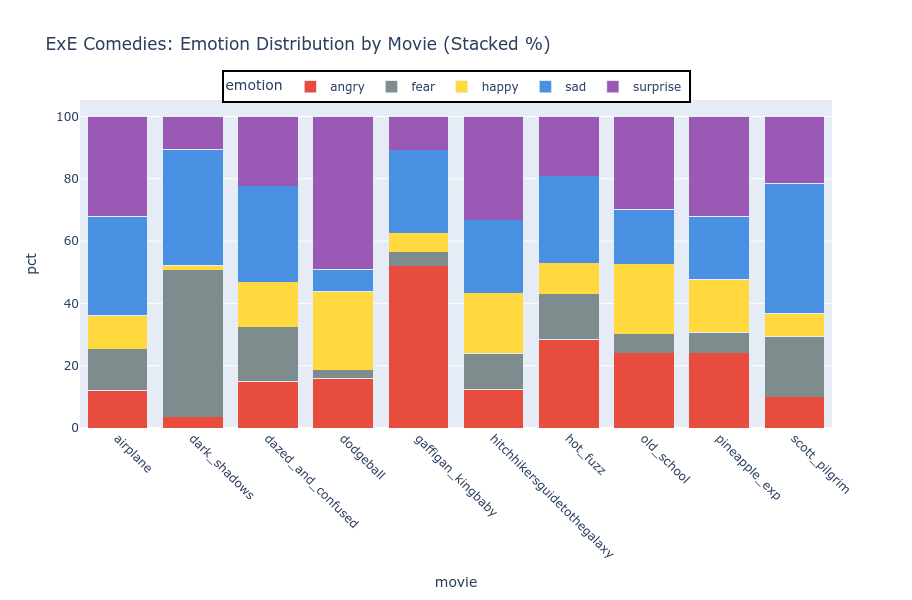

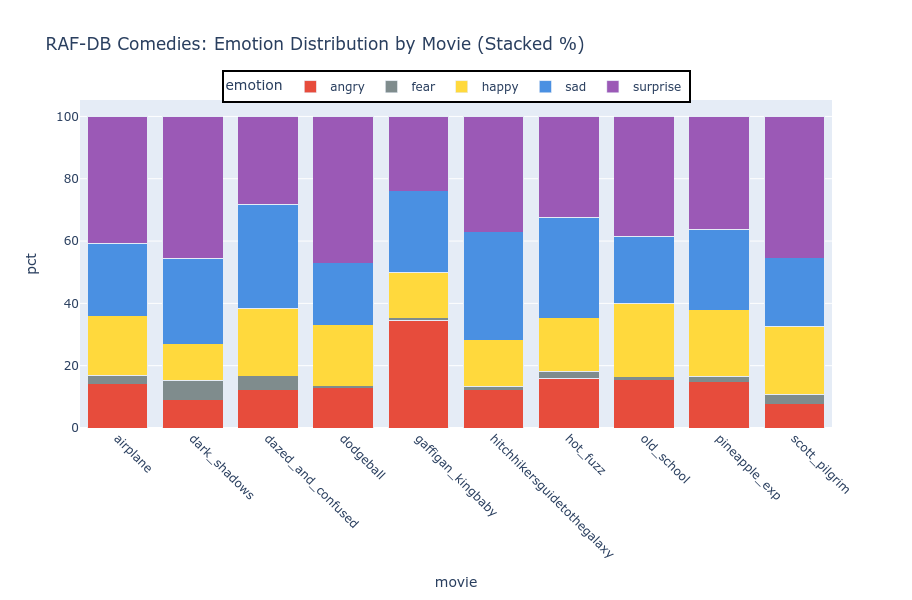

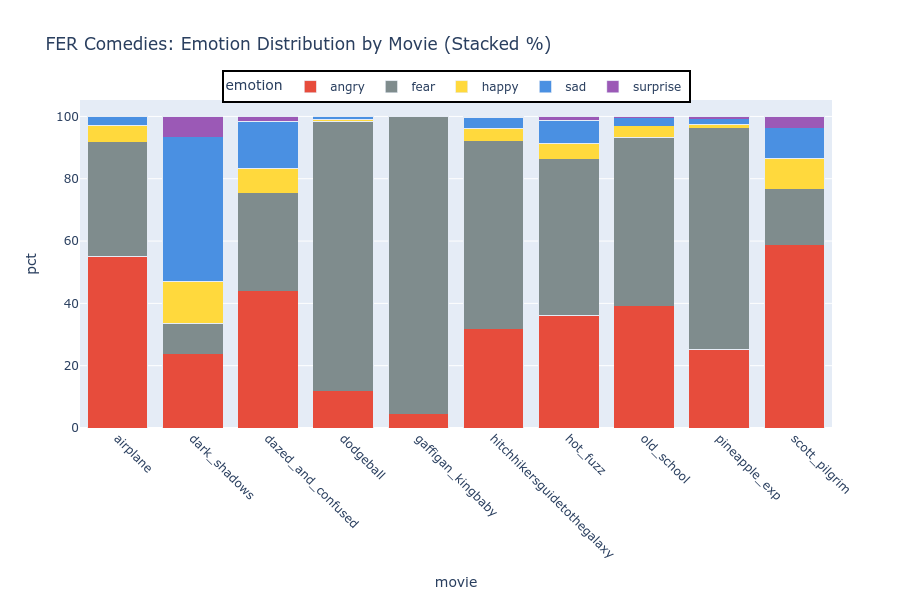

In [12]:
for model, tidy in tidy_dfs.items():
    com_df = tidy.filter(pl.col("movie").is_in(comedies))
    stacked_emo_perc_by_movie(com_df, save_path=save_path, name=model+' Comedies')

In [13]:
crime = ['black_mass',
 'blackkklansman',
 'boondock_saints',
 'domino',
 'lucky_number_slevin',
 'pulp_fiction',
 'seven_psychopaths']

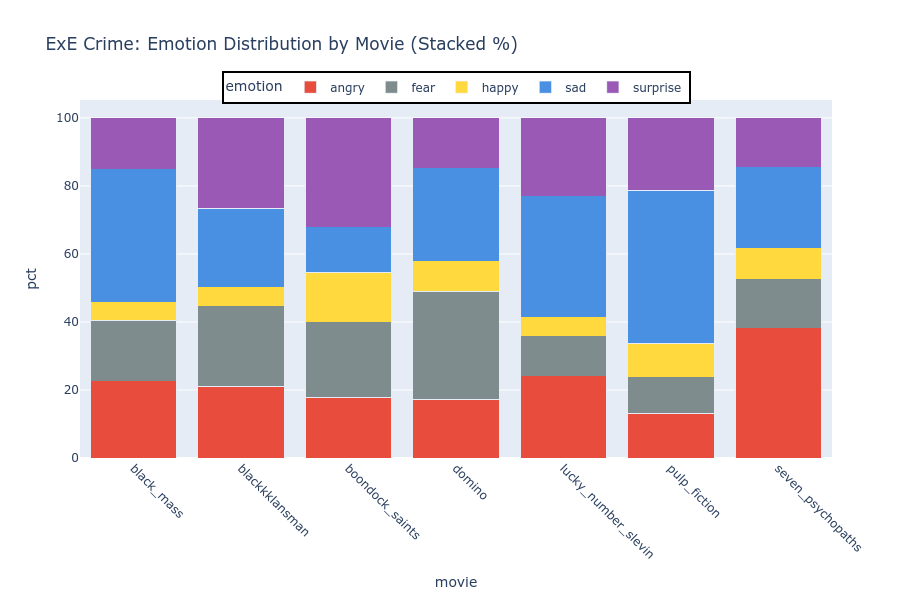

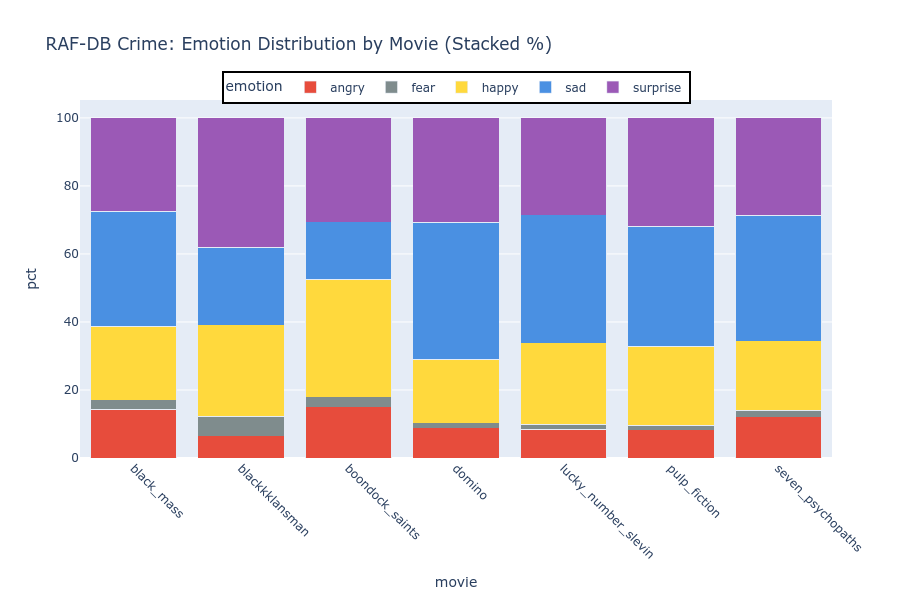

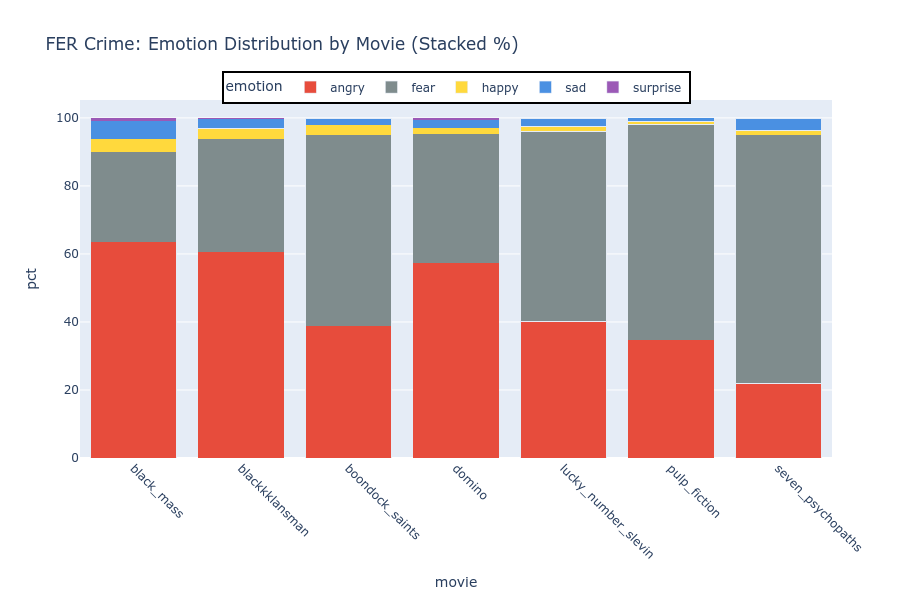

In [14]:
for model, tidy in tidy_dfs.items():
    com_df = tidy.filter(pl.col("movie").is_in(crime))
    stacked_emo_perc_by_movie(com_df, save_path=save_path, name=model+' Crime')

In [15]:
movie_dfs = {}
for model, mdir in movie_dirs.items():
    input_file = mdir / 'all_movies.parquet'
    movie_dfs[model] = pl.read_parquet(input_file)

In [16]:
def plot_emotion_timeline(df, movie_name, confidence_threshold=0.5):
    """
    Plot cumulative emotion counts over movie runtime.
    """
    # Get movie data
    movie_df = (
        df
        .filter(pl.col("movie") == movie_name)
        .filter(pl.col("confidence") >= confidence_threshold)
        .sort("timestamp_sec")
    )
    
    if len(movie_df) == 0:
        print(f"No data for {movie_name}")
        return None
    
    # Create cumulative counts
    emotions = ["angry", "fear", "happy", "sad", "surprise"]
    
    # Initialize cumulative counters
    timeline_data = []
    cumulative = {e: 0 for e in emotions}
    
    for row in movie_df.iter_rows(named=True):
        # Increment the detected emotion
        cumulative[row["emotion"]] += 1
        
        # Record state at this timestamp
        timeline_data.append({
            "timestamp_sec": row["timestamp_sec"],
            "timestamp_min": row["timestamp_sec"] / 60,
            **{f"{e}_count": cumulative[e] for e in emotions}
        })
    
    timeline_df = pl.DataFrame(timeline_data)
    
    # Convert to pandas for plotly
    timeline_pd = timeline_df.to_pandas()
    
    # Create line plot
    fig = go.Figure()
    
    colors = {
        "angry": "#e74c3c",
        "fear": "#9b59b6", 
        "happy": "#f39c12",
        "sad": "#3498db",
        "surprise": "#1abc9c"
    }
    
    for emotion in emotions:
        fig.add_trace(go.Scatter(
            x=timeline_pd["timestamp_min"],
            y=timeline_pd[f"{emotion}_count"],
            mode="lines",
            name=emotion,
            line=dict(color=colors[emotion], width=2),
        ))
    
    fig.update_layout(
        title=f"Emotion Timeline: {movie_name} (confidence ≥ {confidence_threshold})",
        xaxis_title="Time (minutes)",
        yaxis_title="Cumulative Face Count",
        hovermode="x unified",
        height=500,
    )
    
    return fig

In [17]:
def timeline_multiple_models(df_dict, movie_title, save_path=None):
    for name, df in df_dict.items():
        print(name)
        fig = plot_emotion_timeline(df, movie_title, confidence_threshold=0.5)
        if save_path:
            out_name = save_path / f"{name}_timeplot_{movie_title}.png"    
            fig.write_image(out_name)
        fig.show()

In [18]:
all_titles = movie_dfs['ExE']['movie'].unique().to_list()

In [19]:
all_titles.sort()
all_titles

['2_guns',
 '300',
 '47_ronin',
 '9',
 'airplane',
 'amazing_spider-man_the',
 'avengers_age_of_ultron',
 'big_hero_6',
 'black_mass',
 'blackkklansman',
 'boondock_saints',
 'chronicles_of_riddick',
 'dark_knight',
 'dark_knight_rises',
 'dark_shadows',
 'dazed_and_confused',
 'diehard',
 'dodgeball',
 'domino',
 'finding_nemo',
 'frankenweenie',
 'gaffigan_kingbaby',
 'hitchhikersguidetothegalaxy',
 'hot_fuzz',
 'hp1_sorcerers_stone',
 'hp2_chamber_of_secrets',
 'hp3_prisoner_of_azkaban',
 'hp4_goblet_of_fire',
 'hp5_order_phoenix',
 'hp6_half_blood_prince',
 'hp7_deathly_hallows_part_1',
 'hp7_deathly_hallows_part_2',
 'i_am_legend',
 'inception',
 'inside_out',
 'iron_man',
 'iron_man_2',
 'iron_man_3',
 'jurassic_world',
 'kick_ass',
 'kingsman',
 'lego_movie',
 'lotr_1',
 'lotr_2',
 'lotr_3',
 'lucky_number_slevin',
 'mad_max_fury_road',
 'mad_max_thunderdome',
 'old_school',
 'once_upon_a_time_in_mexico_t00',
 'pacific_rim',
 'pineapple_exp',
 'pitch_black',
 'point_break',
 'pu

ExE


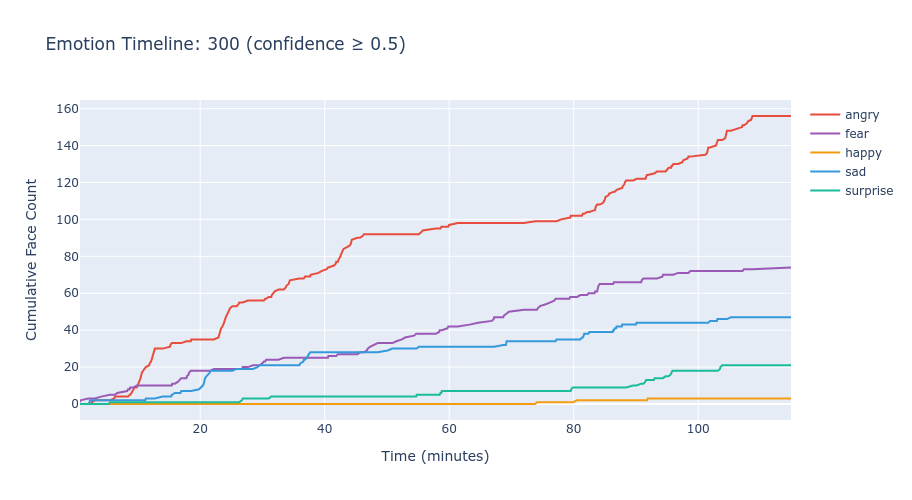

RAF-DB


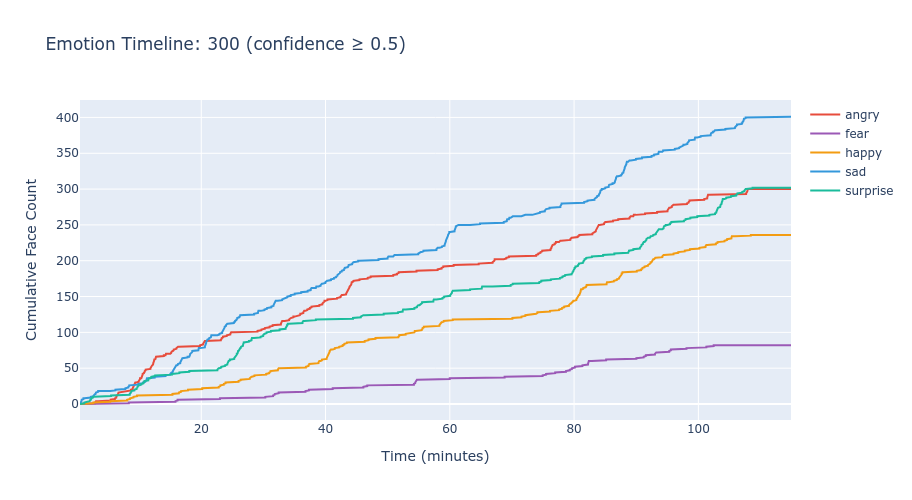

FER


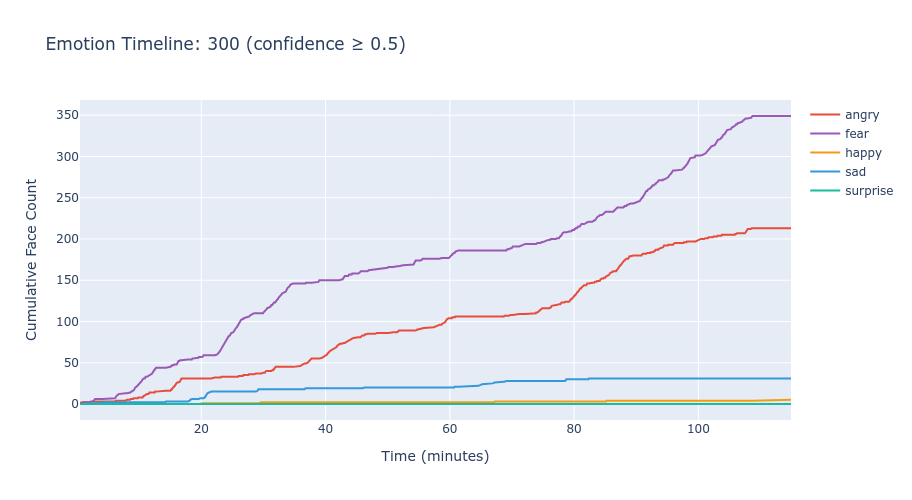

In [20]:
timeline_multiple_models(movie_dfs, "300", save_path=save_path)

ExE


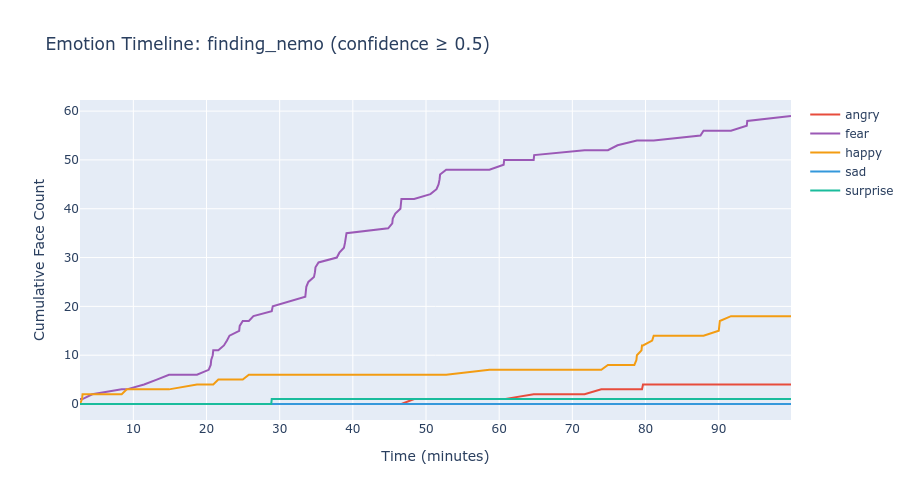

RAF-DB


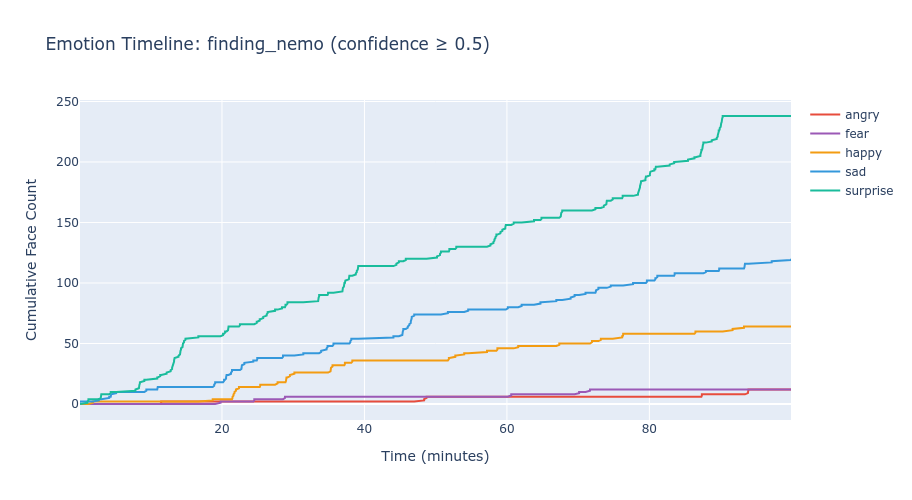

FER


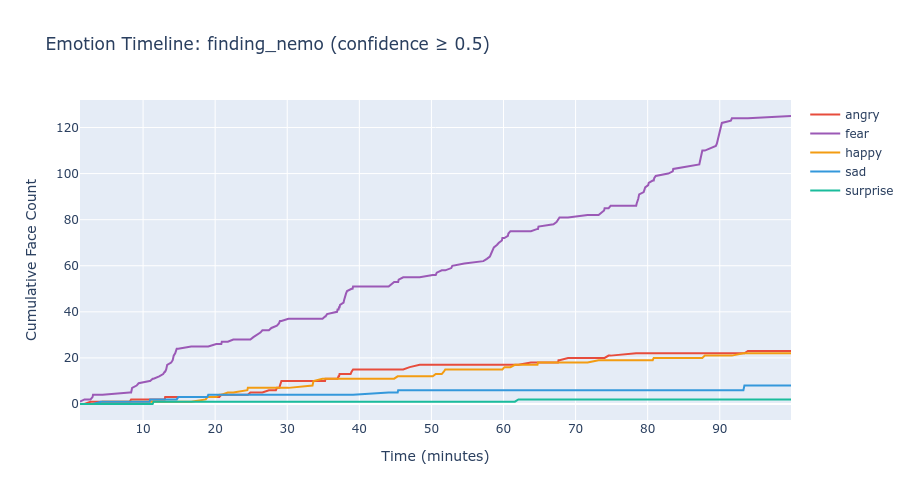

In [21]:
timeline_multiple_models(movie_dfs, "finding_nemo", save_path=save_path)

ExE


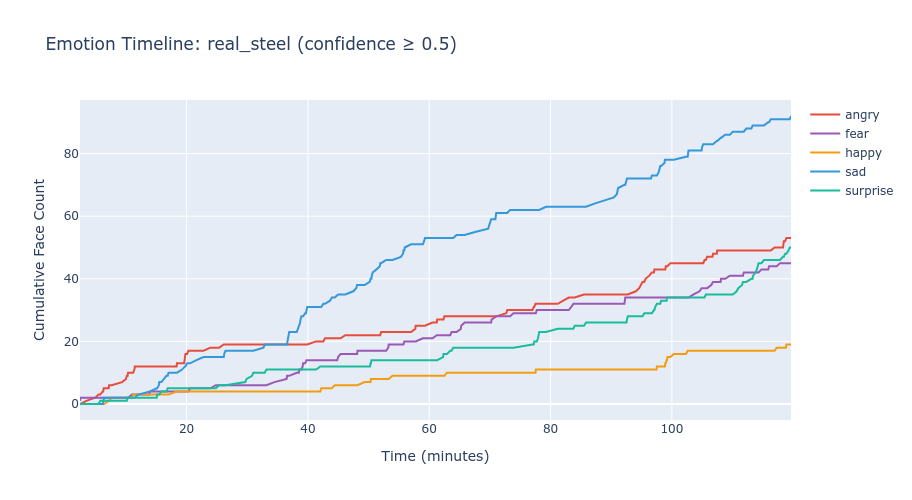

RAF-DB


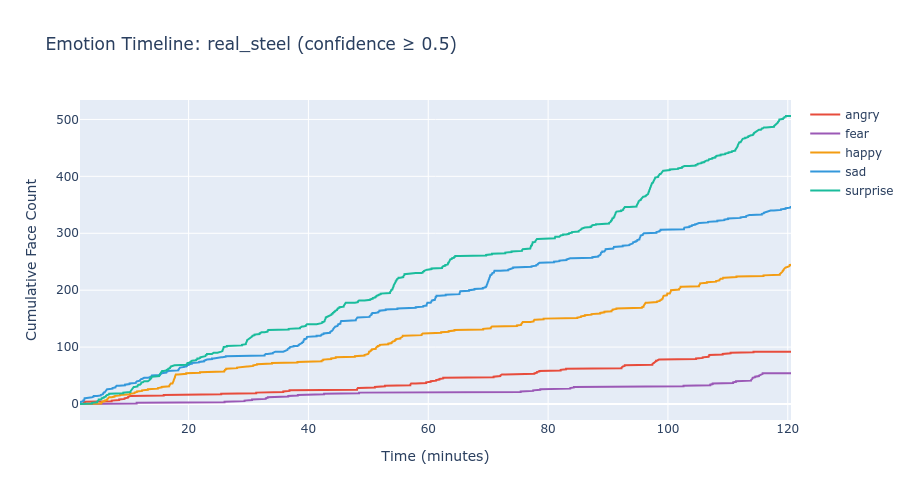

FER


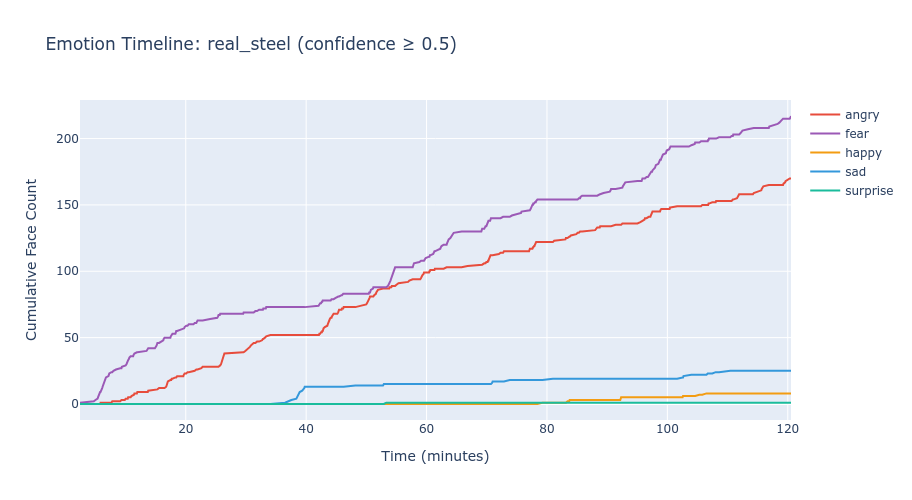

In [22]:
timeline_multiple_models(movie_dfs, "real_steel", save_path=save_path)

In [23]:
hps = ['hp1_sorcerers_stone',
 'hp2_chamber_of_secrets',
 'hp3_prisoner_of_azkaban',
 'hp4_goblet_of_fire',
 'hp5_order_phoenix',
 'hp6_half_blood_prince',
 'hp7_deathly_hallows_part_1',
 'hp7_deathly_hallows_part_2']
# for hp in hps:
#     timeline_multiple_models(movie_dfs, hp, save_path=save_path)

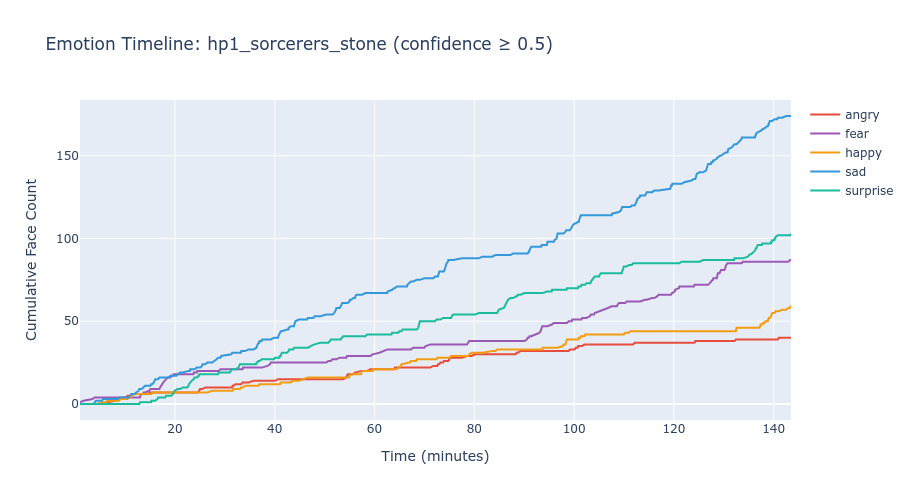

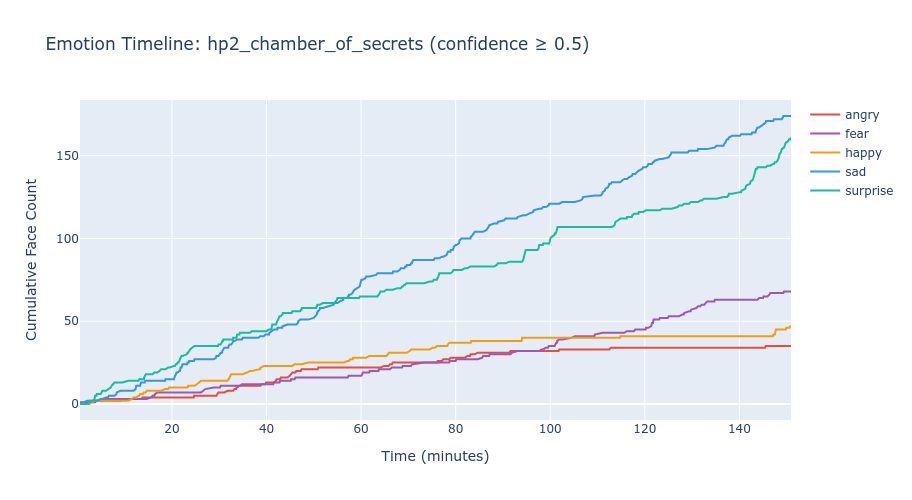

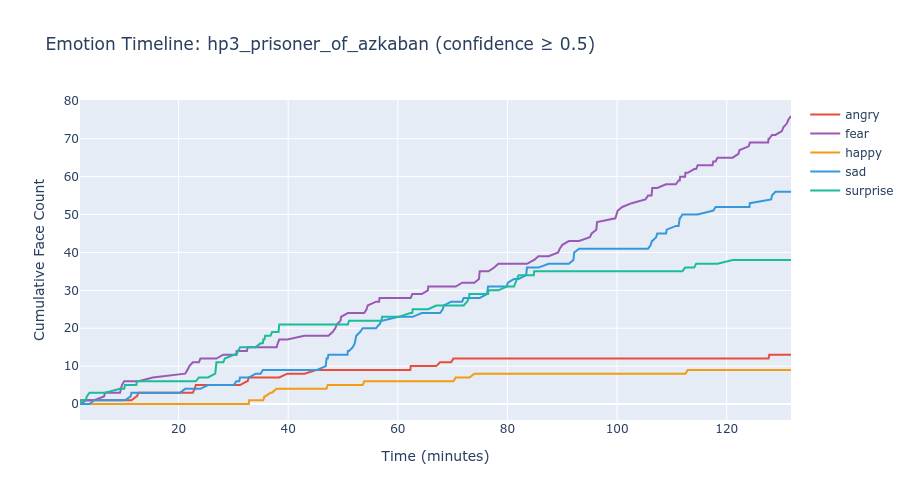

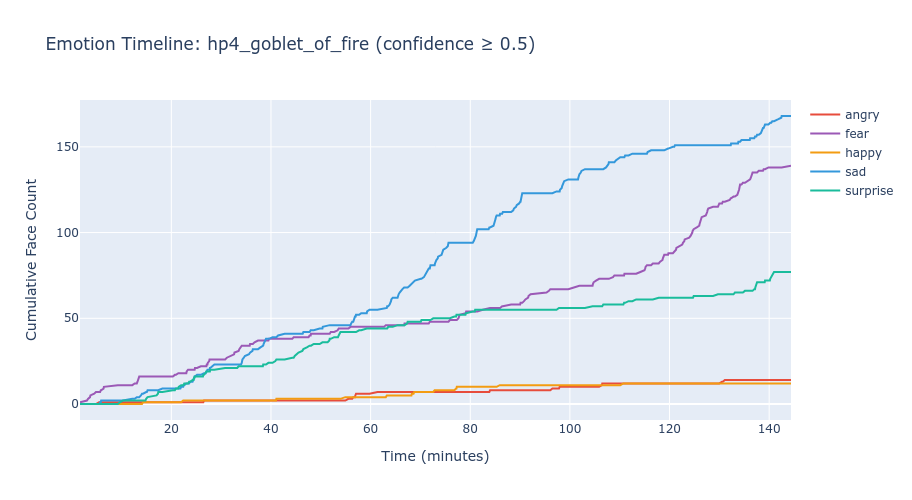

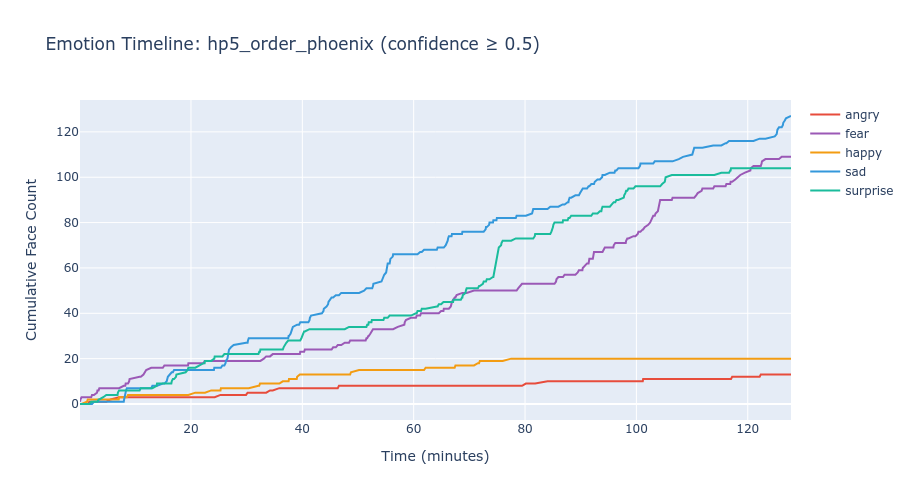

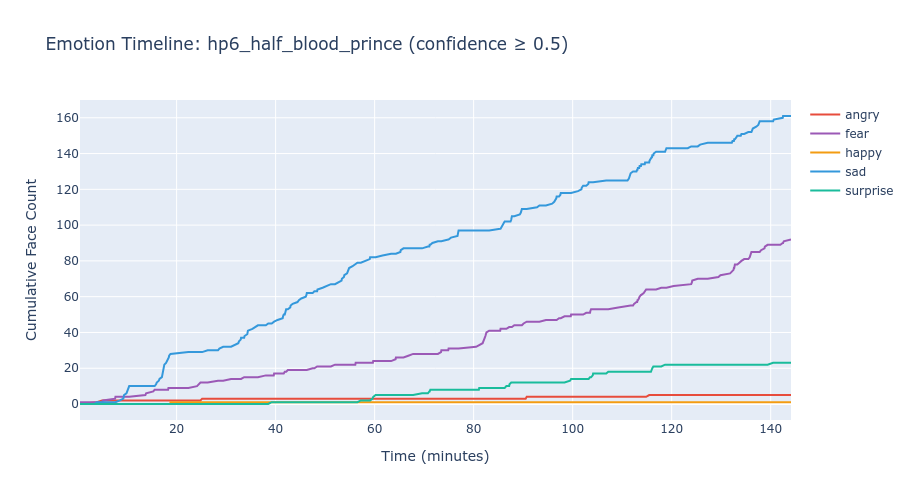

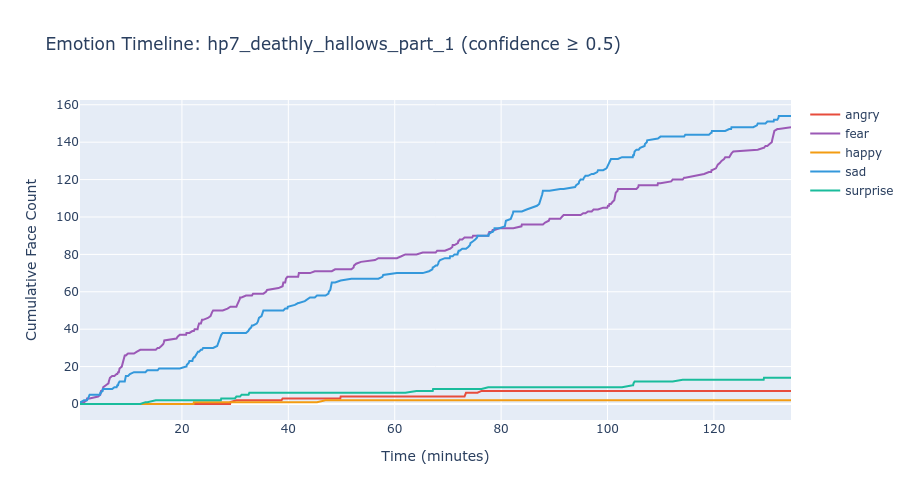

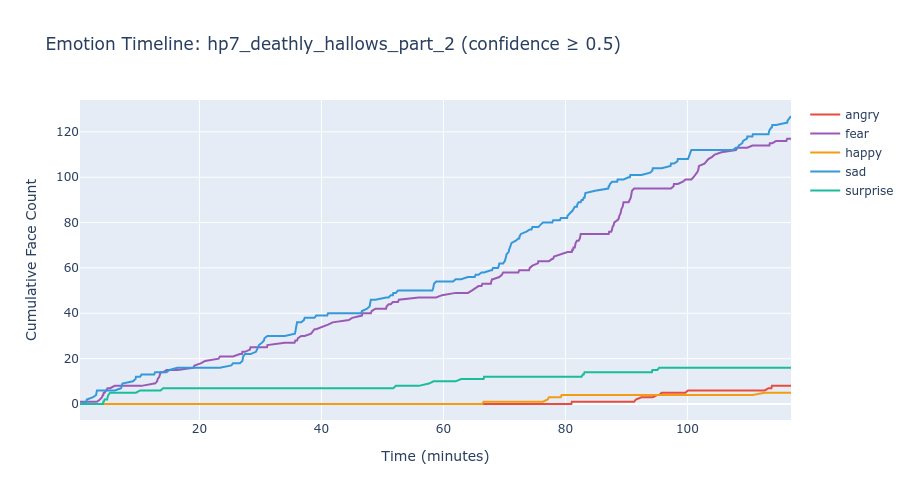

In [24]:
for hp in hps:
    fig = plot_emotion_timeline(
        df=movie_dfs['ExE'], 
        movie_name=hp, confidence_threshold=0.5)
    fig.show()

In [25]:
lotrs = ['lotr_1', 'lotr_2', 'lotr_3']

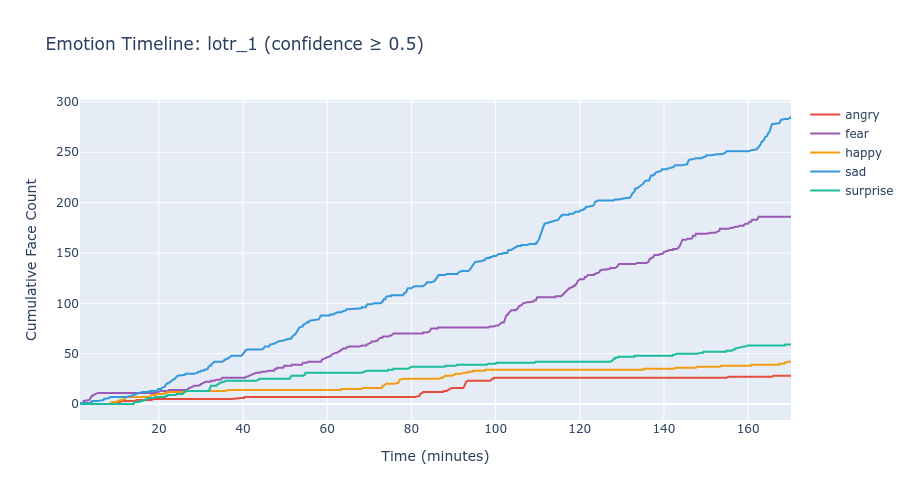

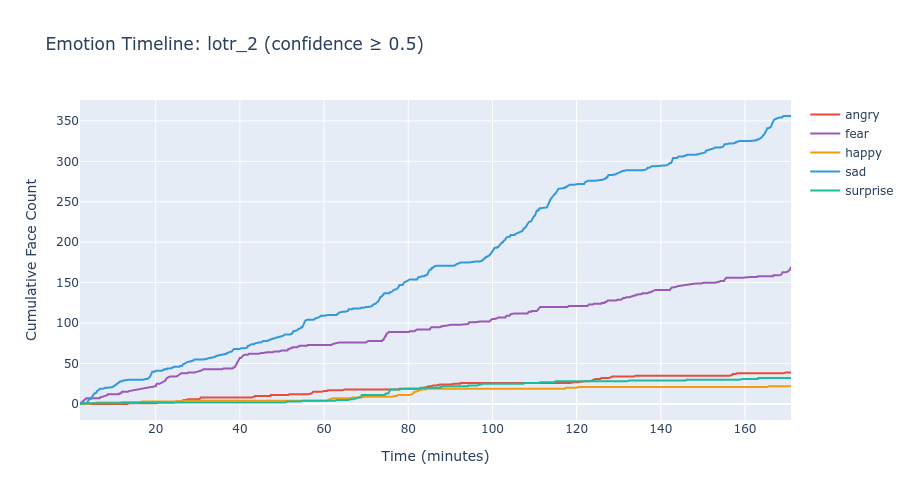

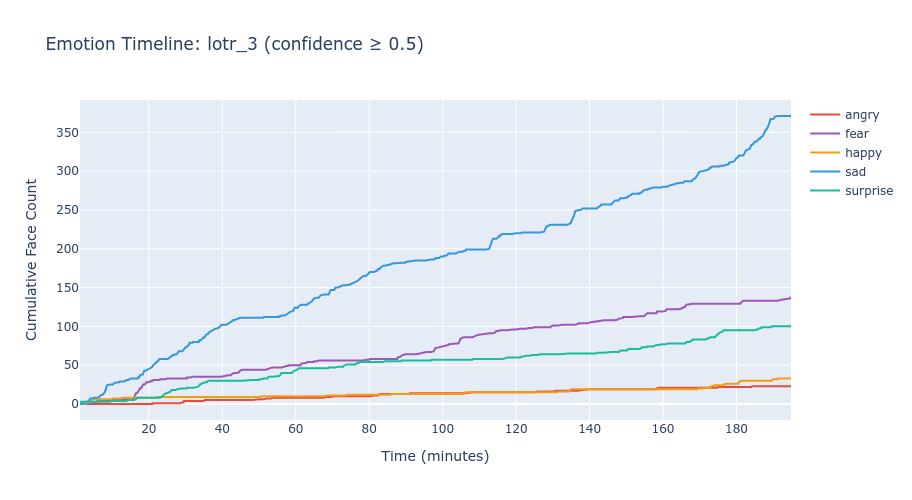

In [26]:
for lotr in lotrs:
    fig = plot_emotion_timeline(
        df=movie_dfs['ExE'], 
        movie_name=lotr, confidence_threshold=0.5)
    fig.show()

ExE


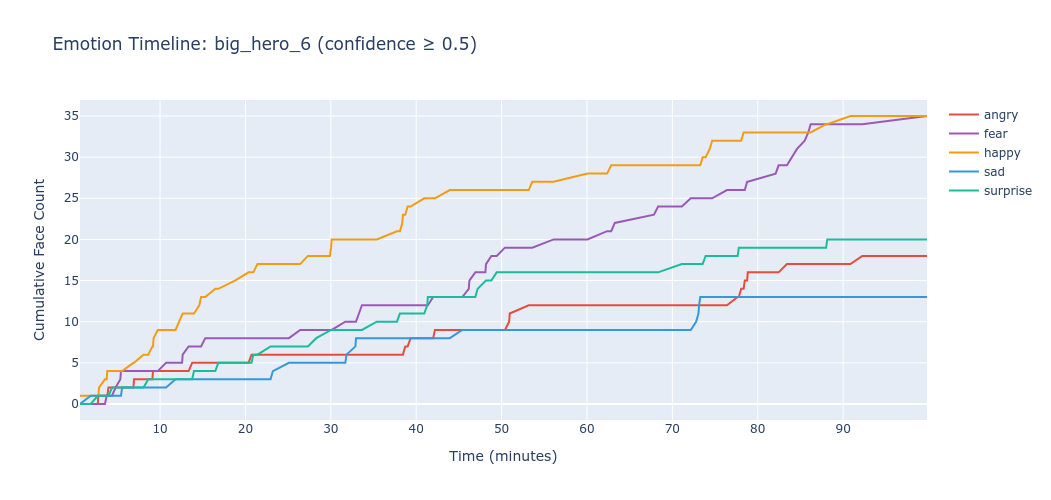

RAF-DB


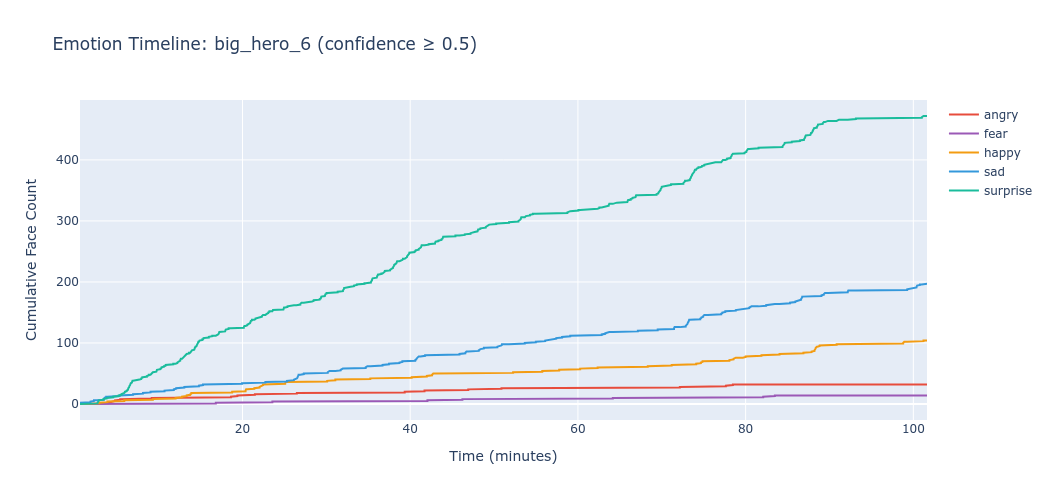

FER


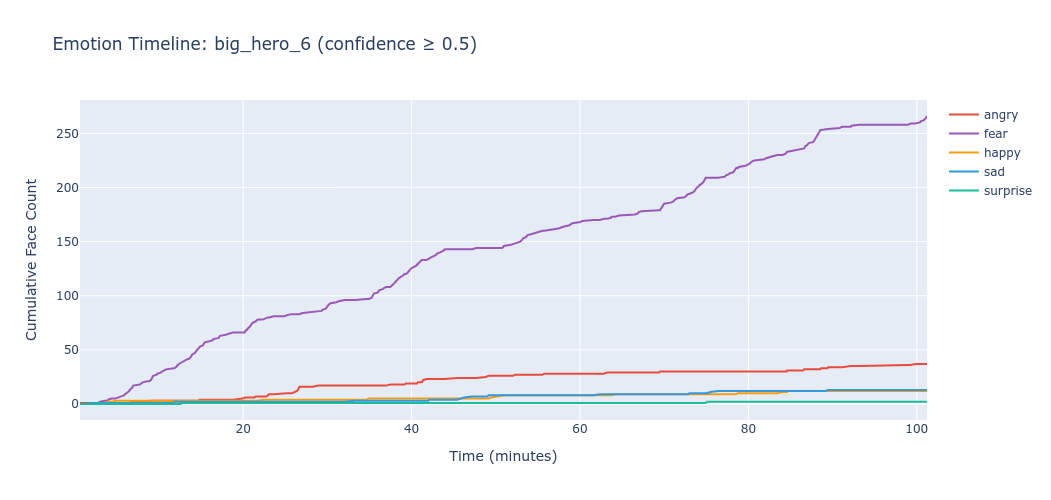

In [34]:
timeline_multiple_models(movie_dfs, "big_hero_6", save_path=save_path)

ExE


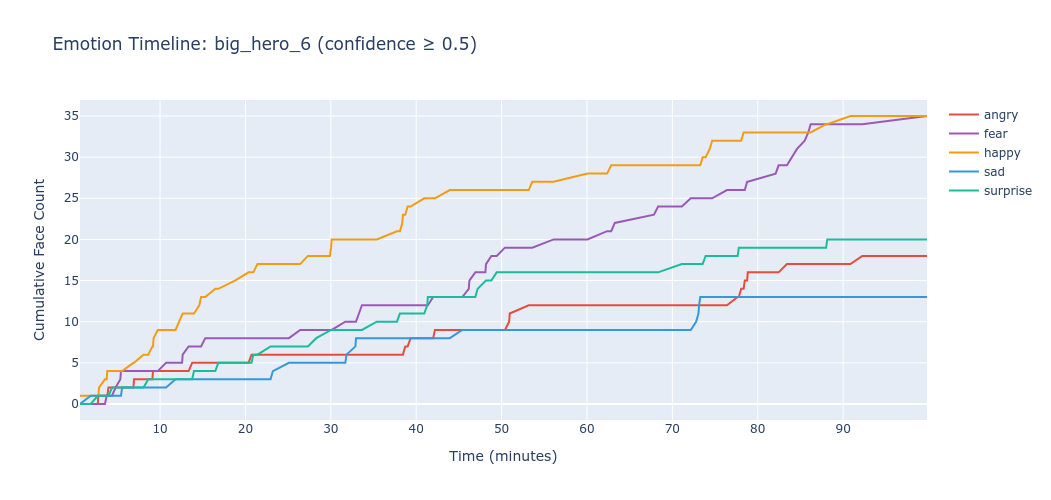

RAF-DB


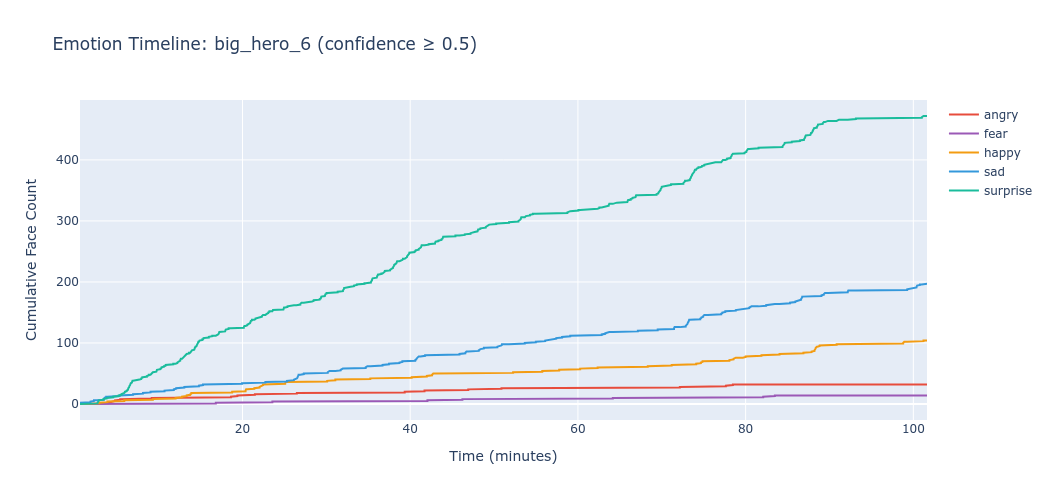

FER


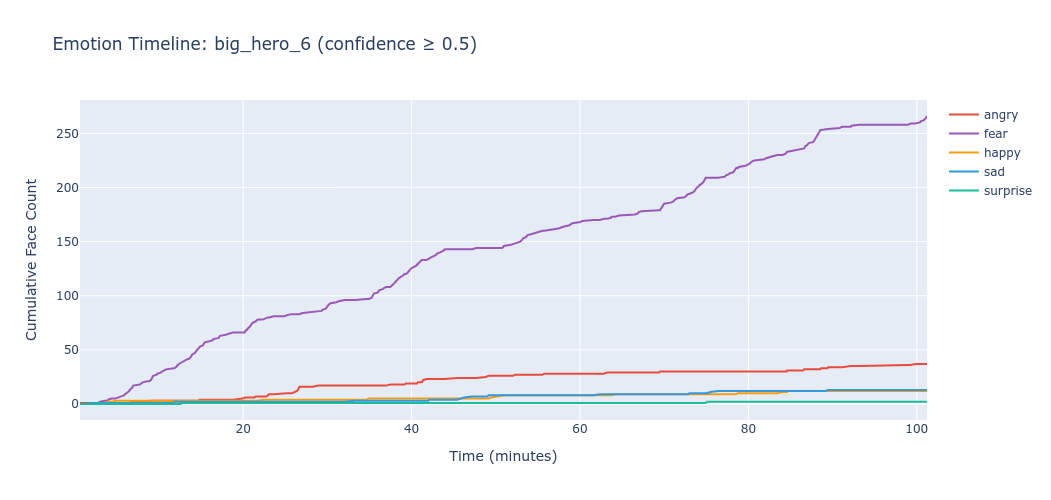

In [39]:
timeline_multiple_models(movie_dfs, "big_hero_6", save_path=save_path)

ExE


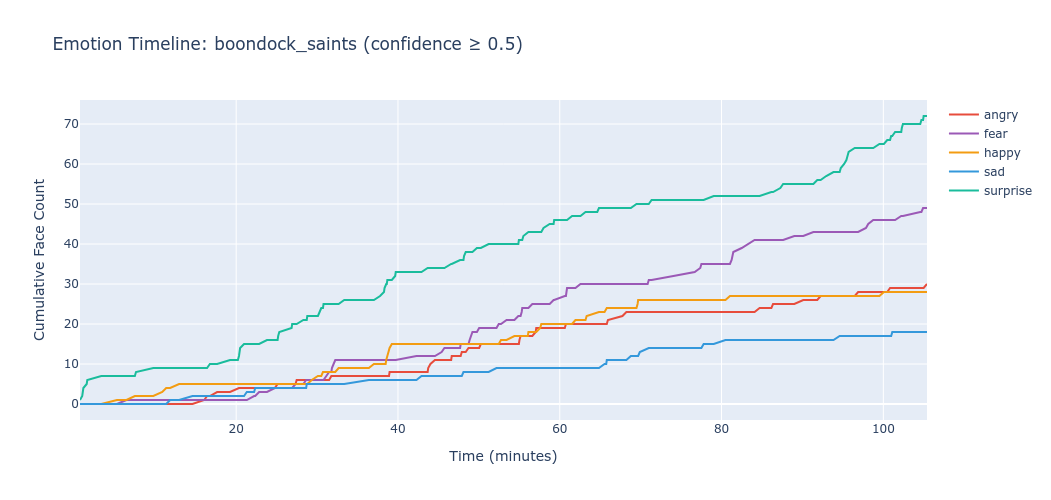

RAF-DB


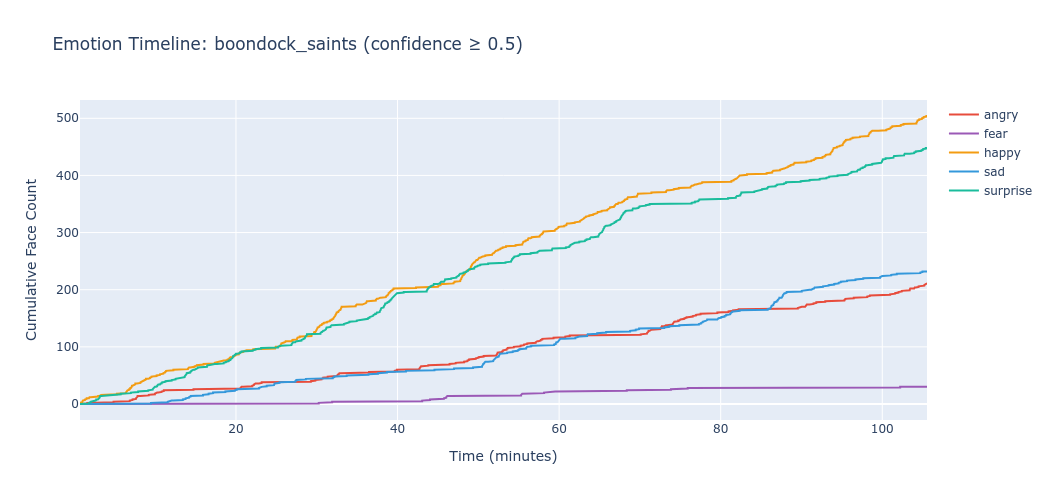

FER


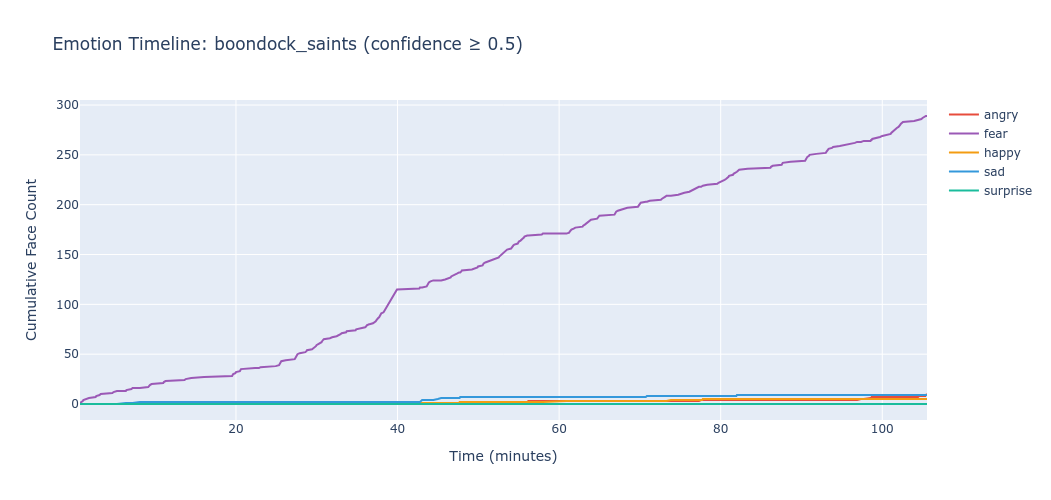

In [40]:
timeline_multiple_models(movie_dfs, "boondock_saints", save_path=save_path)